## Uso y aplicación de los métodos de agrupamiento

Aprendizaje no supervisado

- Jaime Díaz González (coordinador)
- Jordi (secretario)
- Alvaro Navarro Guzmán (revisor)

In [1]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

#### DataSet 1: Lung Disease

The first 5 variables are all blood tests which are thought
to be sensitive to liver disorders that might arise from
excessive alcohol consumption.

https://archive.ics.uci.edu/ml/datasets/liver+disorders

In [2]:
nms=["Mean corpuscular volume", "alkaline phosphotase","alanine aminotransferase", "aspartate aminotransferase",
     "gamma-glutamyl transpeptidase","half-pint aquivalents per day", "split"]

lung=pd.read_table('DataSets/Liver_Disease.csv', sep=';', names =nms )

#Eliminamos la variable "etiqueta" de este dataset y de esta forma transformamos el set de datos en uno en el que 
#desconocemos el agrupamiento.
lung=lung.iloc[:,0:6]
lung.sample(5)

,Mean corpuscular volume,alkaline phosphotase,alanine aminotransferase,aspartate aminotransferase,gamma-glutamyl transpeptidase,half-pint aquivalents per day
112,87,42,26,23,17,4.0
120,96,55,48,39,42,4.0
340,99,75,26,24,41,12.0
174,90,67,77,39,114,8.0
228,82,74,38,28,48,0.5


#### DataSet 2: Zoo Animals

A simple database containing 17 Boolean-valued attributes.

https://archive.ics.uci.edu/ml/datasets/zoo

In [27]:
zoo=pd.read_table('DataSets/Zoo_DataSet.csv', sep=';' , 
                  names = ["animal name", "hair", "feathers", "eggs","milk", "airborne", "aquatic", 
                           "predator", "toothed", "backbone", "breathes","venomous", "fins", "legs",
                           "tail", "domestic", "catsize", "type" ])

#Este será el set de datos del que conocemos el agrupamiento real
zoo.sample(5)

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
40,housefly,1,0,1,0,1,0,0,0,0,1,0,0,6,0,0,0,6
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
53,octopus,0,0,1,0,0,1,1,0,0,0,0,0,8,0,0,1,7
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
35,hamster,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,0,1


#### 0. PREPROCESADO

In [4]:
# DataSet 1: Enfermedad del pulmón
####################################

# Eliminamos las filas en las que haya algún NaN
lung.dropna(inplace=True)
#Estandarizamos las columnas del dataset
standardizer = preprocessing.StandardScaler()
lung_std = standardizer.fit_transform(lung)
# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_lung = pca.fit_transform(lung_std)
principal_lung = pd.DataFrame(data = PCs_lung[:,:2], columns = ['PC 1', 'PC 2'])



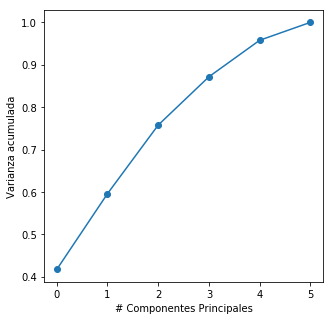

In [5]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

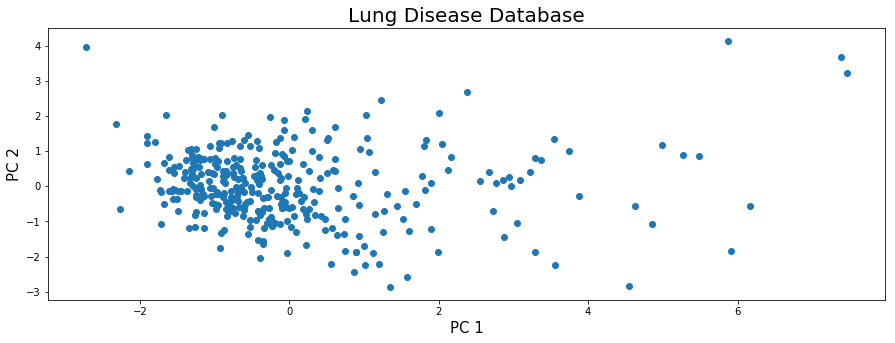

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_lung[:,0],PCs_lung[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Lung Disease Database', fontsize = 20)
plt.show()

In [7]:
# DataSet 2: Animales del Zoo
#################################

# Separamos la primera y la última columna del dataframe
zoo_label=zoo.iloc[:,-1]
zoo=zoo.iloc[:,1:-1]


# Eliminamos las filas en las que haya algún NaN
zoo.dropna(inplace=True)
#Estandarizamos las columnas del dataset
standardizer = preprocessing.StandardScaler()
zoo_std = standardizer.fit_transform(zoo)
# Aplicamos una PCA para poder representar en 2D los atributos sobre los que aplicar las medidas de clustering
pca = PCA()
PCs_zoo = pca.fit_transform(zoo_std)
principal_zoo = pd.DataFrame(data = PCs_zoo[:,:2], columns = ['PC 1', 'PC 2'])



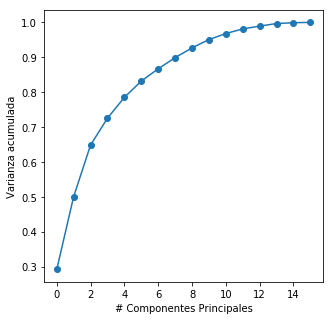

In [8]:
#Comprobamos la varianza acumulada por las PCs de la PCA
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('# Componentes Principales')
plt.ylabel('Varianza acumulada');
plt.show()

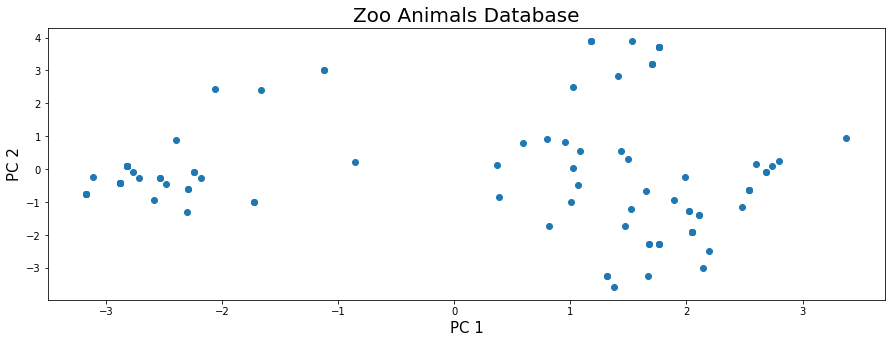

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(PCs_zoo[:,0],PCs_zoo[:,1])
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('Zoo Animals Database', fontsize = 20)
plt.show()

#### 1. AGRUPAMIENTO POR PARTICIONES

#### 2. AGRUPAMIENTO JERÁRQUICO

#### 3. AGRUPAMIENTO ESPECTRAL

In [10]:
#datos Lung: PCs_lung
#datos Zoo: PCs_zoo, zoo_label

#### 4. AGRUPAMIENTO POR DENSIDAD

El valor del error cometido es =  0.13861386138613863


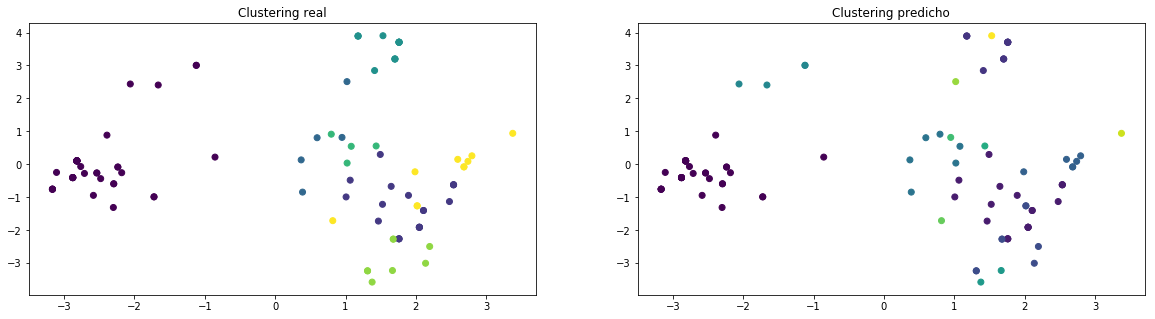

In [78]:
# Vamos a utilizar el método de desplazamiento de media
from sklearn.cluster import MeanShift
from sklearn.metrics import confusion_matrix

h = 3

clustering = MeanShift(bandwidth = h).fit(PCs_zoo)

# Necesito sumar 1 porque el etiquetado predicho empieza incorrectamente por 0
clustering.labels_  = clustering.labels_ + 1

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Clustering real')
ax[0].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = zoo_label)
ax[1].set_title('Clustering predicho')
ax[1].scatter(PCs_zoo[:,0], PCs_zoo[:,1], c = clustering.labels_)

# Calculamos la matriz de confusión
mC = confusion_matrix(zoo_label, clustering.labels_)

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))
    
print('El valor del error cometido es = ', medida_error(mC))

#### 5. AGRUPAMIENTO PROBABILÍSTICO